# Analise de Dados - Obras Gov DF

### 1. Aquisição dos Dados Brutos via API

A primeira etapa consiste em obter os dados diretamente da fonte oficial utilizando a API ObrasGov.br.

* **Fonte:** API ObrasGov.br (`/projeto-investimento`), filtrada para UF=DF.
* **Processo:** Script Python para extração dos dados, incluindo tratamento de paginação (`tamanhoDaPagina`) e tratamento básico de erros (como Rate Limits - 429).
* **Resultado:** Salvamento dos 834 registros brutos extraídos em formato JSON e CSV na pasta `../data/raw/`.

In [56]:
import requests
import time
import json
import pandas as pd

BASE = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"
UF = "DF"
PAGE_SIZE = 100
OUT_JSON = "../data/raw/obrasgov_df.json"
OUT_CSV = "../data/raw/obrasgov_df.csv"

all_items = []
headers = {"User-Agent": "simple-obrasgov/1.0"}

print(f"[start] Coletando dados para UF={UF}...")

page = 0
while True:
    params = {"uf": UF, "pagina": page, "tamanhoDaPagina": PAGE_SIZE}
    print(f"-> Página {page}... ", end="", flush=True)

    while True:
        resp = requests.get(BASE, params=params, headers=headers, timeout=30)
        if resp.status_code == 200:
            data = resp.json().get("content", [])
            print(f"{len(data)} registros.")
            break
        elif resp.status_code == 429:
            print("429 recebido. Aguardando 30s...")
            time.sleep(30)
            continue
        else:
            print(f"Erro {resp.status_code}: {resp.text[:200]}")
            data = []
            break

    if not data:
        print("Nenhum registro encontrado — parando a coleta.")
        break

    all_items.extend(data)
    page += 1
    time.sleep(1) 

print(f"\n✓ Coleta concluída. Total obtido: {len(all_items)} registros.")

# Salvar resultados
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(all_items, f, ensure_ascii=False, indent=2)
pd.DataFrame(all_items).to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

print(f"Arquivos salvos: {OUT_JSON} e {OUT_CSV}")


[start] Coletando dados para UF=DF...
-> Página 0... 100 registros.
-> Página 1... 100 registros.
-> Página 2... 100 registros.
-> Página 3... 100 registros.
-> Página 4... 100 registros.
-> Página 5... 100 registros.
-> Página 6... 100 registros.
-> Página 7... 100 registros.
-> Página 8... 34 registros.
-> Página 9... 0 registros.
Nenhum registro encontrado — parando a coleta.

✓ Coleta concluída. Total obtido: 834 registros.
Arquivos salvos: ../data/raw/obrasgov_df.json e ../data/raw/obrasgov_df.csv


### 2. Carga Inicial e Diagnóstico Básico dos Dados Brutos

Carregamos os dados brutos salvos no CSV para um DataFrame pandas (`df_raw`) e realizamos um diagnóstico inicial para entender a estrutura e a qualidade antes de qualquer tratamento.

* **Ação:** Carga do arquivo `../data/raw/obrasgov_df.csv`.
* **Diagnóstico Inicial:**
    * Visualização das primeiras linhas (`.head()`).
    * Análise da estrutura geral: número de linhas/colunas, tipos de dados (`.info()`).
    * Estatísticas descritivas preliminares para colunas textuais (`.describe(include='object')`).

In [400]:
df_raw = pd.read_csv("../data/raw/obrasgov_df.csv")
display(df_raw.head())
pd.reset_option('display.max_colwidth')

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
0,50379.53-54,DL - 304/2024 - Contratação de instituição par...,NaN,NaN,Contratação de instituição para execução de se...,Ampliação da capacidade de trafego visando a m...,Projetos Básicos e Executivos de Engenharia,2024-12-20,2027-12-05,NaN,...,NaN,False,2024-12-20,[],[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
1,42724.53-27,Escola Classe Crixá São Sebastião,NaN,NaN,"Construção de Escola em Tempo Integral, Escola...",A construção da nova escola beneficiará 977 es...,"Construção de Escola em Tempo Integral, Escola...",2024-09-02,2028-09-02,NaN,...,NaN,False,2025-09-05,[],[{'nome': 'SECRETARIA DE ESTADO DE EDUCACAO DO...,[{'nome': 'FUNDO NACIONAL DE DESENVOLVIMENTO D...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 46, 'descricao': 'Educação', 'idEixo':...","[{'id': 84, 'descricao': 'Educação', 'idTipo':...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
2,19970.53-78,Reajuste do Contrato 45/2021 - Contrução do Ce...,70.602-600,"SAIS Área Especial 3, Setor Policial Sul",Reajuste do Contrato 45/2021 - Construção do C...,Contribuir para a melhor formação dos bombeiro...,Construção de um novo centro de formação e de ...,2021-09-14,2024-08-28,NaN,...,NaN,False,2023-02-06,[],[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,[{'nome': 'CORPO DE BOMBEIROS MILITAR DO DISTR...,"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 1, 'descricao': 'Segurança Pública', '...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
3,24797.53-15,Implantação de Passarelas nas Estradas Parque ...,NaN,NaN,Implantação de passarelas de estrutura mista n...,"Pedestres, no geral, demanda das ocupações lin...",Implantação de passarelas de estrutura mista n...,2023-08-30,2028-08-30,NaN,...,NaN,False,2023-08-28,[],[{'nome': 'DEPARTAMENTO DE ESTRADAS DE RODAGEM...,"[{'nome': 'MINISTÉRIO DAS CIDADES', 'codigo': ...","[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 24, 'descricao': 'Infraestrutura Urban...","[{'id': 57, 'descricao': 'Obra de Arte Especia...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
4,24822.53-70,"obra de construção da Cabine de Medição, loca...",NaN,NaN,"obra de construção da Cabine de Medição, loca...",A demanda de carga elétrica do Campus Darcy Ri...,A demanda de carga elétrica do Campus Darcy Ri...,2023-09-14,2024-03-14,NaN,...,NaN,False,2023-08-29,[],"[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'id': 3, 'descricao': 'Econômico'}, {'id': 3...","[{'id': 31, 'descricao': 'Energia', 'idEixo': ...","[{'id': 95, 'descricao': 'Subestação', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


In [401]:
print("--- Informações Gerais do DataFrame ---")
df_raw.info()

--- Informações Gerais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   idUnico                             834 non-null    object
 1   nome                                834 non-null    object
 2   cep                                 347 non-null    object
 3   endereco                            351 non-null    object
 4   descricao                           834 non-null    object
 5   funcaoSocial                        834 non-null    object
 6   metaGlobal                          834 non-null    object
 7   dataInicialPrevista                 831 non-null    object
 8   dataFinalPrevista                   831 non-null    object
 9   dataInicialEfetiva                  22 non-null     object
 10  dataFinalEfetiva                    4 non-null      object
 11  dataCadastro      

In [402]:
# Estatísticas descritivas para colunas de texto (object)
print("\n--- Estatísticas para Colunas Categóricas (Texto) ---")
display(df_raw.describe(include=['object']))


--- Estatísticas para Colunas Categóricas (Texto) ---


,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
count,834,834,347,351,834,834,834,831,831,22,...,128,597,834,834,834,834,834,834,834,834
unique,667,620,89,232,607,488,455,406,443,13,...,2,2,358,49,78,54,16,51,78,497
top,74143.53-04,CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,1,BR-010,CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,Segurança Pública,Escola de Educação Infantil Tipo B,2025-06-01,2027-06-01,2018-07-09,...,Informações Obras Fundo Nacional de Desenvolvi...,False,2025-07-25,[],[{'nome': 'FUNDO NACIONAL DE DESENVOLVIMENTO D...,[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 36, 'descricao': 'Dragagem, Derrocamen...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
freq,3,11,87,11,11,45,52,27,29,6,...,127,563,92,497,128,367,319,129,127,141


### 3. Tratamento e Engenharia de Dados

Nesta etapa crucial, aplicamos transformações para limpar, enriquecer e estruturar os dados, preparando-os para a análise.

* **Cópia de Trabalho:** Criação do DataFrame `df_tratado`.
* **Normalização de Nomes:** Padronização dos nomes das colunas para `snake_case`.
* **Remoção de Duplicatas:** Eliminação de registros com `id_unico` repetido (mantendo a primeira ocorrência).
* **Diagnóstico Pós-Deduplicação:** Reanálise dos valores ausentes (`.isnull().sum()`) sobre os dados únicos.
* **Conversão de Tipos (Inicial):** Transformação das colunas de data para `datetime64[ns]` e das colunas numéricas (`qdt_empregos_gerados`, `populacao_beneficiada`) para `float64`.
* **Engenharia de Features (Flattening):** Expansão das colunas estruturadas (`executores`, `eixos`, etc.) em novas colunas "achatadas" (`executor_nome`, `eixo_descricao`, `origem_recurso`, etc.).
* **Cálculo de Métrica:** Criação da coluna `valor_total_previsto`.
* **Limpeza Final:** Remoção das colunas originais que se tornaram redundantes após a expansão.
* **Otimização de Tipos:** Conversão final das colunas `object` restantes para os tipos `string`, `category` e `boolean`, otimizando o uso de memória.

In [403]:
# Cria uma cópia do DataFrame original para realizar os tratamentos
df_tratado = df_raw.copy()

# Renomeia as colunas para o padrão snake_case (ex: idUnico -> id_unico)
df_tratado.columns = (df_tratado.columns
                      .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                      .str.lower()
                     )
print(df_tratado.columns)


Index(['id_unico', 'nome', 'cep', 'endereco', 'descricao', 'funcao_social',
       'meta_global', 'data_inicial_prevista', 'data_final_prevista',
       'data_inicial_efetiva', 'data_final_efetiva', 'data_cadastro',
       'especie', 'natureza', 'natureza_outras', 'situacao',
       'desc_plano_nacional_politica_vinculado', 'uf', 'qdt_empregos_gerados',
       'desc_populacao_beneficiada', 'populacao_beneficiada',
       'observacoes_pertinentes', 'is_modelada_por_bim', 'data_situacao',
       'tomadores', 'executores', 'repassadores', 'eixos', 'tipos',
       'sub_tipos', 'fontes_de_recurso'],
      dtype='object')


In [404]:
# Remove as linhas duplicadas com base na coluna 'idUnico', mantendo a primeira ocorrência
df_tratado.drop_duplicates(subset=['id_unico'], keep='first', inplace=True)
print(f"Após remoção de duplicatas, o DataFrame agora tem {df_tratado.shape[0]} registros únicos.")

Após remoção de duplicatas, o DataFrame agora tem 667 registros únicos.


In [405]:
# Calcula a quantidade e a porcentagem de valores nulos por coluna
print("--- Análise de Valores Nulos por Coluna ---")
null_counts = df_tratado.isnull().sum()
null_percentage = (null_counts / len(df_tratado)) * 100

# Cria um DataFrame para exibir os resultados de forma clara
null_analysis = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Porcentagem (%)': null_percentage.round(2)
})

# Exibe apenas as colunas que têm valores nulos, ordenadas da maior para a menor
print(null_analysis[null_analysis['Valores Nulos'] > 0].sort_values(by='Porcentagem (%)', ascending=False))



--- Análise de Valores Nulos por Coluna ---
                                        Valores Nulos  Porcentagem (%)
data_final_efetiva                                663            99.40
data_inicial_efetiva                              646            96.85
natureza_outras                                   601            90.10
observacoes_pertinentes                           573            85.91
populacao_beneficiada                             539            80.81
qdt_empregos_gerados                              537            80.51
desc_populacao_beneficiada                        535            80.21
desc_plano_nacional_politica_vinculado            440            65.97
cep                                               379            56.82
endereco                                          372            55.77
is_modelada_por_bim                               200            29.99
especie                                             3             0.45
data_inicial_prevista            

In [406]:
colunas_de_data = [
    'data_inicial_prevista',
    'data_final_prevista',
    'data_inicial_efetiva',
    'data_final_efetiva',
    'data_cadastro',
    'data_situacao'
]

# Loop para converter cada coluna para datetime
for coluna in colunas_de_data:
    df_tratado[coluna] = pd.to_datetime(df_tratado[coluna], errors='coerce')

print("Colunas de data convertidas para o tipo datetime.")

# Verifica os tipos de dados das colunas de data após a conversão
print("\nTipos de dados das colunas de data após a conversão:")
print(df_tratado[colunas_de_data].dtypes)

Colunas de data convertidas para o tipo datetime.

Tipos de dados das colunas de data após a conversão:
data_inicial_prevista    datetime64[ns]
data_final_prevista      datetime64[ns]
data_inicial_efetiva     datetime64[ns]
data_final_efetiva       datetime64[ns]
data_cadastro            datetime64[ns]
data_situacao            datetime64[ns]
dtype: object


In [407]:
# Lista de colunas que devem ser numéricas
colunas_numericas = ['qdt_empregos_gerados','populacao_beneficiada']

for coluna in colunas_numericas:
    # A função pd.to_numeric é a forma correta de fazer essa conversão.

    df_tratado[coluna] = pd.to_numeric(df_tratado[coluna], errors='coerce')

# Verificando os tipos de dados após a conversão para confirmar
print("\nTipos de dados das colunas numéricas após a conversão:")
print(df_tratado[colunas_numericas].dtypes)


Tipos de dados das colunas numéricas após a conversão:
qdt_empregos_gerados     float64
populacao_beneficiada    float64
dtype: object


In [408]:
import ast

# Expande uma coluna com uma string de lista de dicionários em múltiplas colunas
def expandir_coluna_estruturada(df, coluna_origem, mapeamento_chaves, separador=', '):
    dados_extraidos = {novo_nome: [] for novo_nome in mapeamento_chaves.values()}
    for texto_lista in df[coluna_origem]:
        valores_por_linha = {novo_nome: [] for novo_nome in mapeamento_chaves.values()}
        try:
            lista = ast.literal_eval(str(texto_lista))
            if isinstance(lista, list):
                for item_dict in lista:
                    for chave_original, novo_nome in mapeamento_chaves.items():
                        valor = item_dict.get(chave_original)
                        if valor is not None:
                            valores_por_linha[novo_nome].append(str(valor))
        except (ValueError, SyntaxError):
            pass
        for novo_nome, valores in valores_por_linha.items():
            # Usamos um set para juntar apenas valores únicos e depois ordenamos
            dados_extraidos[novo_nome].append(separador.join(sorted(list(set(valores)))))
    for novo_nome, lista_valores in dados_extraidos.items():
        df[novo_nome] = lista_valores
    return df

# Fontes de recurso, é necessário somar os valores previstos
def extrair_valor_total(texto_lista):
    try:
        lista = ast.literal_eval(str(texto_lista))
        if isinstance(lista, list):
            return sum(d.get('valorInvestimentoPrevisto', 0) for d in lista if isinstance(d, dict))
        return 0.0
    except (ValueError, SyntaxError):
        return 0.0

print("Iniciando a expansão das colunas estruturadas...")

df_tratado = expandir_coluna_estruturada(df_tratado, 'executores', {'nome': 'executor_nome', 'codigo': 'executor_codigo'})

df_tratado = expandir_coluna_estruturada(df_tratado, 'eixos', {'id': 'eixo_id', 'descricao': 'eixo_descricao'})

df_tratado = expandir_coluna_estruturada(df_tratado, 'tipos', {'id': 'tipo_id', 'descricao': 'tipo_descricao'})

df_tratado = expandir_coluna_estruturada(df_tratado, 'sub_tipos', {'id': 'subtipo_id', 'descricao': 'subtipo_descricao'})


df_tratado = expandir_coluna_estruturada(df_tratado, 'fontes_de_recurso', {'origem': 'origem_recurso'})


df_tratado['valor_total_previsto'] = df_tratado['fontes_de_recurso'].apply(extrair_valor_total)

print("\n✓ Colunas estruturadas expandidas com sucesso.")

colunas_para_exibir = ['id_unico', 'executor_nome', 'eixo_descricao', 'origem_recurso', 'valor_total_previsto']
pd.set_option('display.max_colwidth', None)
print("\nExibindo resultado da expansão:")
display(df_tratado[colunas_para_exibir].head())
pd.reset_option('display.max_colwidth')

Iniciando a expansão das colunas estruturadas...

✓ Colunas estruturadas expandidas com sucesso.

Exibindo resultado da expansão:


,id_unico,executor_nome,eixo_descricao,origem_recurso,valor_total_previsto
0,50379.53-54,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,Econômico,Federal,"44,463,443.00"
1,42724.53-27,SECRETARIA DE ESTADO DE EDUCACAO DO DISTRITO FEDERAL,Social,Federal,"12,319,519.51"
2,19970.53-78,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,Administrativo,Federal,"1,177,429.91"
3,24797.53-15,DEPARTAMENTO DE ESTRADAS DE RODAGEM DO DISTRITO FEDERAL,Econômico,Federal,"10,800,000.00"
4,24822.53-70,FUNDACAO UNIVERSIDADE DE BRASILIA,Econômico,Federal,"928,139.70"


In [409]:
# Colunas que se tornaram redundantes após a expansão
colunas_redundantes = [
    'tomadores', 
    'executores', 
    'repassadores', 
    'eixos', 
    'tipos', 
    'sub_tipos', 
    'fontes_de_recurso'
]

print("Removendo colunas originais redundantes")
colunas_antes = df_tratado.shape[1]

df_tratado = df_tratado.drop(columns=colunas_redundantes)

print(df_tratado.columns)

Removendo colunas originais redundantes
Index(['id_unico', 'nome', 'cep', 'endereco', 'descricao', 'funcao_social',
       'meta_global', 'data_inicial_prevista', 'data_final_prevista',
       'data_inicial_efetiva', 'data_final_efetiva', 'data_cadastro',
       'especie', 'natureza', 'natureza_outras', 'situacao',
       'desc_plano_nacional_politica_vinculado', 'uf', 'qdt_empregos_gerados',
       'desc_populacao_beneficiada', 'populacao_beneficiada',
       'observacoes_pertinentes', 'is_modelada_por_bim', 'data_situacao',
       'executor_nome', 'executor_codigo', 'eixo_id', 'eixo_descricao',
       'tipo_id', 'tipo_descricao', 'subtipo_id', 'subtipo_descricao',
       'origem_recurso', 'valor_total_previsto'],
      dtype='object')


In [410]:
colunas_categoricas = [
    'especie', 'natureza', 'situacao', 'uf', 
    'eixo_descricao', 'tipo_descricao', 'subtipo_descricao', 'executor_nome'
]

colunas_string = [
    'id_unico', 'nome', 'cep', 'endereco', 'descricao', 'funcao_social', 'meta_global',
    'natureza_outras', 'desc_plano_nacional_politica_vinculado',
    'desc_populacao_beneficiada', 'observacoes_pertinentes',
    'executor_codigo', 'eixo_id', 'tipo_id', 'subtipo_id'
]

# Converte para 'category'
for coluna in colunas_categoricas:
    if coluna in df_tratado.columns:
        df_tratado[coluna] = df_tratado[coluna].astype('category')

# Converte para 'string'
for coluna in colunas_string:
    if coluna in df_tratado.columns:
        df_tratado[coluna] = df_tratado[coluna].astype('string')

# Converte para 'boolean'
df_tratado['is_modelada_por_bim'] = df_tratado['is_modelada_por_bim'].astype('boolean')

print("\n--- Estrutura Final do DataFrame 'df_tratado'---")
df_tratado.info()


--- Estrutura Final do DataFrame 'df_tratado'---
<class 'pandas.core.frame.DataFrame'>
Index: 667 entries, 0 to 833
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   id_unico                                667 non-null    string        
 1   nome                                    667 non-null    string        
 2   cep                                     288 non-null    string        
 3   endereco                                295 non-null    string        
 4   descricao                               667 non-null    string        
 5   funcao_social                           667 non-null    string        
 6   meta_global                             667 non-null    string        
 7   data_inicial_prevista                   665 non-null    datetime64[ns]
 8   data_final_prevista                     665 non-null    datetime64[ns]
 9   data_inic

### 4. Armazenamento e Preparação Final para Análise

Concluímos a fase de engenharia de dados salvando o dataset master tratado e criando uma versão focada para a visualização.

* **Armazenamento do Master:** Salvamento do DataFrame `df_tratado` (completo e otimizado) na tabela `projetos_investimento` do banco SQLite (`../db/obras_df.db`). Inclui verificação da gravação com consulta SQL.
* **Criação do Dataset de Análise:** Carregamento dos dados a partir do SQLite e criação do DataFrame `df_analise`, removendo colunas não essenciais para a análise visual.
* **Filtragem para Análise:** Remoção de registros com valores simbólicos (`valor_total_previsto` <= R$ 1) do `df_analise`.
* **Análise de Valores Mínimos:** Exibição dos 5 projetos com menores valores no `df_analise` (após filtragem).
* **Salvamento do Dataset de Análise:** Exportação do `df_analise` final para CSV (`../data/processed/obras_df_para_analise.csv`).

In [411]:
from sqlalchemy import create_engine
import os

# --- Configurações do Banco de Dados  ---
db_dir = "../db"
db_path = os.path.join(db_dir, "obras_df.db")
# NOVO NOME DA TABELA
table_name = "projetos_investimento"

os.makedirs(db_dir, exist_ok=True)

try:
    engine = create_engine(f'sqlite:///{db_path}')
    df_tratado.to_sql(table_name, engine, if_exists='replace', index=False)
    
    print(f"\n✓ Sucesso! Os {len(df_tratado)} registros foram salvos na tabela '{table_name}'.")

except Exception as e:
    print(f"\n Ocorreu um erro ao salvar no banco de dados: {e}")


✓ Sucesso! Os 667 registros foram salvos na tabela 'projetos_investimento'.


In [412]:
# Célula de Verificação com Consulta Analítica (Versão Corrigida)

print("--- Executando consulta para encontrar os 5 maiores projetos em execução ---")

try:
    # CORREÇÃO: Trocamos 'executor_principal' pelo nome correto da coluna, 'executor_nome'.
    sql_query = """
    SELECT
        nome AS "Nome do Projeto",
        executor_nome AS "Executor",
        valor_total_previsto AS "Valor Previsto (R$)"
    FROM
        projetos_investimento
    WHERE
        situacao = 'Em execução'
    ORDER BY
        valor_total_previsto DESC
    LIMIT 5
    """
    
    # Conecta ao banco e executa a consulta
    with engine.connect() as connection:
        df_top5_projetos = pd.read_sql_query(sql_query, connection)
    
    # Formata a coluna de valor para melhor legibilidade
    df_top5_projetos['Valor Previsto (R$)'] = df_top5_projetos['Valor Previsto (R$)'].apply(lambda x: f"R$ {x:,.2f}")
    pd.set_option('display.max_colwidth', None)
    display(df_top5_projetos)
    pd.reset_option('display.max_colwidth')
except Exception as e:
    print(f"Não foi possível ler os dados do banco de dados: {e}")

--- Executando consulta para encontrar os 5 maiores projetos em execução ---


,Nome do Projeto,Executor,Valor Previsto (R$)
0,PROJETO ESTRATÉGICO SISFRON (SISTEMA INTEGRADO DE MONITORAMENTO DE FRONTEIRAS),COMANDO DO EXÉRCITO,"R$ 839,664,954.32"
1,26.782.3006.7XT1.0053,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,"R$ 359,130,057.13"
2,00 00680/2023,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,"R$ 352,994,609.29"
3,26.782.2087.7R82.0052,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,"R$ 130,653,710.13"
4,PNCV,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,"R$ 104,133,733.23"


In [413]:
import pandas as pd
from sqlalchemy import create_engine

# Carrega os dados do banco de dados
engine = create_engine(f'sqlite:///../db/obras_df.db')
df_from_sql = pd.read_sql_table(
    "projetos_investimento",
    engine,
    parse_dates=['data_inicial_prevista', 'data_final_prevista', 'data_inicial_efetiva',
                 'data_final_efetiva', 'data_cadastro', 'data_situacao']
)

# Remove colunas com muitos valores nulos ou com pouca relevância para a análise
colunas_para_remover = [
    'meta_global', 'natureza_outras', 'desc_plano_nacional_politica_vinculado',
    'desc_populacao_beneficiada', 'observacoes_pertinentes', 'executor_codigo',
    'eixo_id', 'tipo_id', 'subtipo_id', 'data_inicial_efetiva',
    'data_final_efetiva', 'endereco', 'qdt_empregos_gerados', 'populacao_beneficiada'
]

# Cria o DataFrame final para análise
df_analise = df_from_sql.drop(columns=colunas_para_remover)

df_analise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_unico               667 non-null    object        
 1   nome                   667 non-null    object        
 2   cep                    288 non-null    object        
 3   descricao              667 non-null    object        
 4   funcao_social          667 non-null    object        
 5   data_inicial_prevista  665 non-null    datetime64[ns]
 6   data_final_prevista    665 non-null    datetime64[ns]
 7   data_cadastro          667 non-null    datetime64[ns]
 8   especie                664 non-null    object        
 9   natureza               667 non-null    object        
 10  situacao               667 non-null    object        
 11  uf                     667 non-null    object        
 12  is_modelada_por_bim    467 non-null    object        
 13  data_

In [414]:
print("Exibindo estatísticas descritivas para as colunas numéricas do 'df_analise':")

pd.options.display.float_format = '{:,.2f}'.format

display(df_analise.select_dtypes(exclude=['datetime']).describe())


Exibindo estatísticas descritivas para as colunas numéricas do 'df_analise':


,valor_total_previsto
count,667.00
mean,"12,582,092.96"
std,"58,344,839.35"
min,0.00
25%,"86,217.59"
50%,"1,280,000.00"
75%,"5,934,000.00"
max,"1,000,000,001.00"


In [415]:
print("--- Analisando os 5 menores valores de projetos ---")
df_menores_valores = df_analise.nsmallest(5, 'valor_total_previsto')[['nome', 'executor_nome', 'valor_total_previsto']]
df_menores_valores['valor_total_previsto'] = df_menores_valores['valor_total_previsto'].apply(lambda x: f"R$ {x:,.2f}")
pd.set_option('display.max_colwidth', None)
display(df_menores_valores)
pd.reset_option('display.max_colwidth')

--- Analisando os 5 menores valores de projetos ---


,nome,executor_nome,valor_total_previsto
43,OBRA DE REFORMA DO ACESSO PRINCIPAL DA FACULDADE DE CIÊNCIA DA INFORMAÇÃO,FUNDACAO UNIVERSIDADE DE BRASILIA,R$ 0.00
325,"Construção, Reforma e Ampliação dos Prédios da Codevasf",COMPANHIA DE DESENVOLVIMENTO DOS VALES DO SÃO FRANCISCO E DO PARNAÍBA,R$ 0.00
35,Implantação de infraestrutura de apoio às atividades produtivas - Sede em 2025,COMPANHIA DE DESENVOLVIMENTO DOS VALES DO SÃO FRANCISCO E DO PARNAÍBA,R$ 0.01
37,PAC 2 - CRECHE/PRÉ-ESCOLA 001,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCAÇÃO,R$ 0.01
74,Reconstrução CAIC Castello Branco - Distrito Federal - DF,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCAÇÃO,R$ 0.01


In [416]:
#quantidade de projetos com valor simbólico
qtd_inicial =len(df_analise)
#remove projetos com valor simbólico (<= R$ 1)
df_analise = df_analise[df_analise['valor_total_previsto'] > 1]
print(f"\nNúmero de projetos removidos com valor simbólico (< R$ 1) : {qtd_inicial-len(df_analise)}")


Número de projetos removidos com valor simbólico (< R$ 1) : 110


In [417]:
print("--- Analisando os 5 menores valores de projetos ---")
df_menores_valores = df_analise.nsmallest(5, 'valor_total_previsto')[['nome', 'executor_nome', 'valor_total_previsto']]
df_menores_valores['valor_total_previsto'] = df_menores_valores['valor_total_previsto'].apply(lambda x: f"R$ {x:,.2f}")
pd.set_option('display.max_colwidth', None)
display(df_menores_valores)
pd.reset_option('display.max_colwidth')


--- Analisando os 5 menores valores de projetos ---


,nome,executor_nome,valor_total_previsto
353,Projetos e estudos técnicos para obras 16º BPM/ PMDF. (BRAZLANDIA),Polícia Militar do Distrito Federal,"R$ 4,684.45"
448,Projeto de monitoramento eletrônico e alarmes para Demap e Direp,SRRF01 - SUPERINTENDÊNCIA REGIONAL DA RECEITA FEDERAL DO BRASIL DA 1ª REGIÃO FISCAL,"R$ 7,500.00"
95,"contratação de empresa especializada para elaboração dos projetos básico e executivo da reforma da cobertura do Instituto Nacional de Identificação,",DEPARTAMENTO DE POLICIA FEDERAL,"R$ 8,000.00"
329,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,"R$ 10,000.00"
118,"Contratação de empresa especializada em desenvolver projetos estruturais e execução de sondagem de solo do estande de tiros do Comando de Operações Táticas - COT da Polícia Federal, localizado setor p",DEPARTAMENTO DE POLICIA FEDERAL,"R$ 12,500.00"


## 5. Análise Exploratória e Visualização de Dados 

Utilizando o DataFrame `df_analise` final (carregado, limpo e filtrado), exploramos os dados para responder perguntas-chave através de gráficos.

* **Visualizações:** Criação de histogramas e gráficos de barras para ilustrar padrões e tendências.
* **Insights e Conclusões:** Interpretação dos gráficos e apresentação das descobertas de forma objetiva.

Cada subseção a seguir aborda uma pergunta específica e apresenta o gráfico correspondente e sua interpretação.



---

### Análise 1: Qual a distribuição do valor total previsto para os projetos?

Após a remoção de 110 projetos com valores simbólicos (menores que R$ 1,00), investigamos a distribuição de custos dos projetos restantes. O histograma com escala logarítmica nos permite observar a forma dessa distribuição em várias ordens de magnitude.

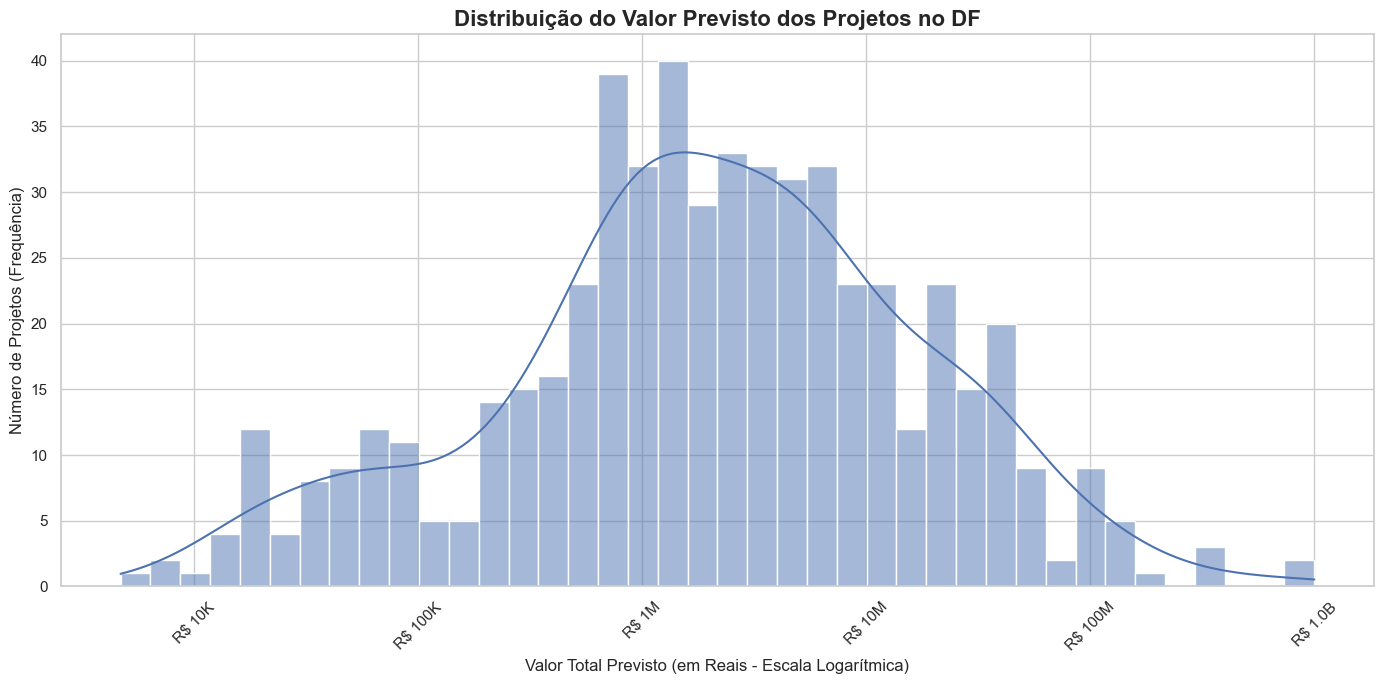

In [418]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Configurações de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

# Criação do Gráfico
ax = sns.histplot(data=df_analise, x='valor_total_previsto', bins=40, kde=True, log_scale=True)

# Customização do Gráfico
ax.set_title('Distribuição do Valor Previsto dos Projetos no DF', fontsize=16, weight='bold')
ax.set_xlabel('Valor Total Previsto (em Reais - Escala Logarítmica)', fontsize=12)
ax.set_ylabel('Número de Projetos (Frequência)', fontsize=12)

def format_currency(x, pos):
    if x >= 1_000_000_000: return f'R$ {x/1_000_000_000:.1f}B'
    if x >= 1_000_000: return f'R$ {x/1_000_000:.0f}M'
    if x >= 1_000: return f'R$ {x/1_000:.0f}K'
    return f'R$ {x:.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Insight da Análise 1:**

1.  **Concentração de Investimentos:** O pico do gráfico está claramente localizado na faixa entre **R$ 1 milhão e R$ 10 milhões**. Isso indica que o projeto mais comum no DF é uma obra de médio porte. A grande maioria dos esforços e recursos está concentrada nesta faixa de valor.

2.  **"Cauda Longa" à Direita:** A curva se estende para a direita até a marca de R$ 1 bilhão. Essa "cauda" representa um número muito pequeno de projetos de altíssimo custo. São as megaobras que, embora poucas em quantidade, representam uma parcela significativa do valor total investido.

3.  **Poucos Projetos de Baixo Custo:** Há relativamente poucos projetos nas faixas de valores mais baixas (abaixo de R$ 100 mil), sugerindo que o foco não está em microintervenções, mas sim em projetos de maior impacto.

Em resumo, a estratégia de investimento do DF parece ser focada em um grande volume de projetos de médio porte (na casa de R$ 1 a R$ 10 milhões), complementada por um número seletivo de obras de grande escala que superam os R$ 100 milhões.

---

### Análise 2: Como evoluiu o cadastro de projetos e investimentos ao longo do tempo?

Esta análise temporal investiga a evolução do número de projetos cadastrados e do volume de investimentos previstos ano a ano. Podemos comparar a tendência da quantidade de projetos com a tendência do valor total investido, identificando anos de maior ou menor atividade de planejamento de obras no Distrito Federal.

Gerando o gráfico de linhas com escala do eixo Y corrigida...


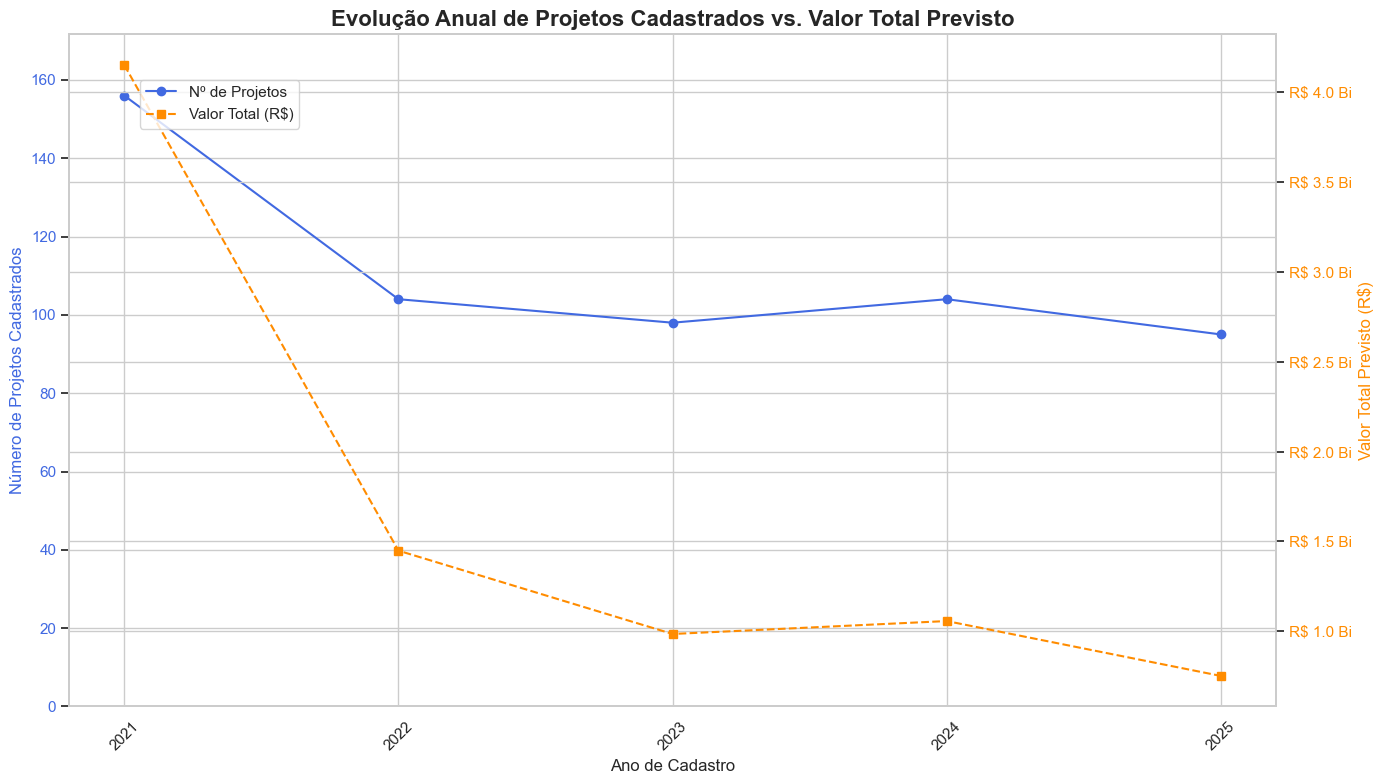


--- Tabela de Dados da Análise Temporal ---


,ano_cadastro,contagem_projetos,soma_valor_previsto
0,2021,156,"R$ 4,152,224,776.39"
1,2022,104,"R$ 1,448,382,290.29"
2,2023,98,"R$ 984,406,353.84"
3,2024,104,"R$ 1,056,416,876.29"
4,2025,95,"R$ 750,825,701.96"


In [419]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

# --- Preparação dos Dados (se necessário, caso tenha reiniciado o kernel) ---
if 'ano_cadastro' not in df_analise.columns:
    df_analise['ano_cadastro'] = df_analise['data_cadastro'].dt.year
    analise_temporal = df_analise.groupby('ano_cadastro').agg(
        contagem_projetos=('id_unico', 'count'),
        soma_valor_previsto=('valor_total_previsto', 'sum')
    ).reset_index()

# --- Criação do Gráfico de Eixo Duplo (Versão Corrigida) ---
print("Gerando o gráfico de linhas com escala do eixo Y corrigida...")

fig, ax1 = plt.subplots(figsize=(14, 8), dpi=100)
sns.set_theme(style="whitegrid")

# Plota a linha da contagem de projetos
color1 = 'royalblue'
ax1.set_xlabel('Ano de Cadastro', fontsize=12)
ax1.set_ylabel('Número de Projetos Cadastrados', fontsize=12, color=color1)
ax1.plot(analise_temporal['ano_cadastro'], analise_temporal['contagem_projetos'], color=color1, marker='o', label='Nº de Projetos')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)

# --- AJUSTE PRINCIPAL: Forçar o eixo Y da contagem a começar em zero ---
# Isso evita a percepção de uma queda exagerada.
# Adicionamos um pequeno espaço no topo (10%) para o gráfico "respirar".
ax1.set_ylim(bottom=0, top=analise_temporal['contagem_projetos'].max() * 1.1)
# --- FIM DO AJUSTE ---

# Cria o segundo eixo para o valor
ax2 = ax1.twinx()
color2 = 'darkorange'
ax2.set_ylabel('Valor Total Previsto (R$)', fontsize=12, color=color2)
ax2.plot(analise_temporal['ano_cadastro'], analise_temporal['soma_valor_previsto'], color=color2, marker='s', linestyle='--', label='Valor Total (R$)')
ax2.tick_params(axis='y', labelcolor=color2)

# Formata o eixo Y do valor para moeda
def format_currency_axis(x, pos):
    if x >= 1_000_000_000: return f'R$ {x/1_000_000_000:.1f} Bi'
    if x >= 1_000_000: return f'R$ {x/1_000_000:.0f} Mi'
    return f'R$ {x/1_000_000:.2f} Mi'
ax2.yaxis.set_major_formatter(FuncFormatter(format_currency_axis))

# Finalização do Gráfico
plt.title('Evolução Anual de Projetos Cadastrados vs. Valor Total Previsto', fontsize=16, weight='bold')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# --- Tabela de Dados Complementar (sem alterações) ---
print("\n--- Tabela de Dados da Análise Temporal ---")
display(analise_temporal.style.format({
    'ano_cadastro': '{:.0f}',
    'contagem_projetos': '{:,.0f}',
    'soma_valor_previsto': 'R$ {:,.2f}'
}))

**Insight da Análise 2:**

O gráfico de linhas revela uma tendência clara no cadastro de projetos de investimento, marcada por um pico  em **2021**. Nesse ano, foram cadastrados **156 projetos**, totalizando um valor previsto de **R$ 4,15 bilhões**.

Após 2021, observa-se uma queda e posterior estabilização. O número de projetos cadastrados anualmente fica em torno de 100, e o valor total em cerca de R$ 1 bilhão por ano.

É interessante notar que as duas linhas (quantidade e valor) seguem um padrão muito similar. Isso sugere que o pico de 2021 não foi causado por um único "megaprojeto", mas sim por um aumento geral tanto no número quanto no valor médio dos projetos cadastrados naquele ano.

Houve um "boom" no planejamento de novas obras e investimentos no DF em 2021(um ano antes da elição). Desde então, o ritmo de cadastro de novos projetos diminuiu, mas se mantém em um patamar consistente e elevado, com cerca de 100 novos projetos sendo planejados a cada ano.

### Análise 3: Para quais setores os investimentos estão sendo direcionados?

Após entendermos *quando* os projetos foram cadastrados, esta análise busca responder *para onde* os investimentos estão indo. Vamos agrupar os projetos por seu eixo temático (`eixo_descricao`) e somar o valor total previsto para cada um.

Preparando os dados para a análise setorial...
Gerando o gráfico Treemap por setor de investimento...


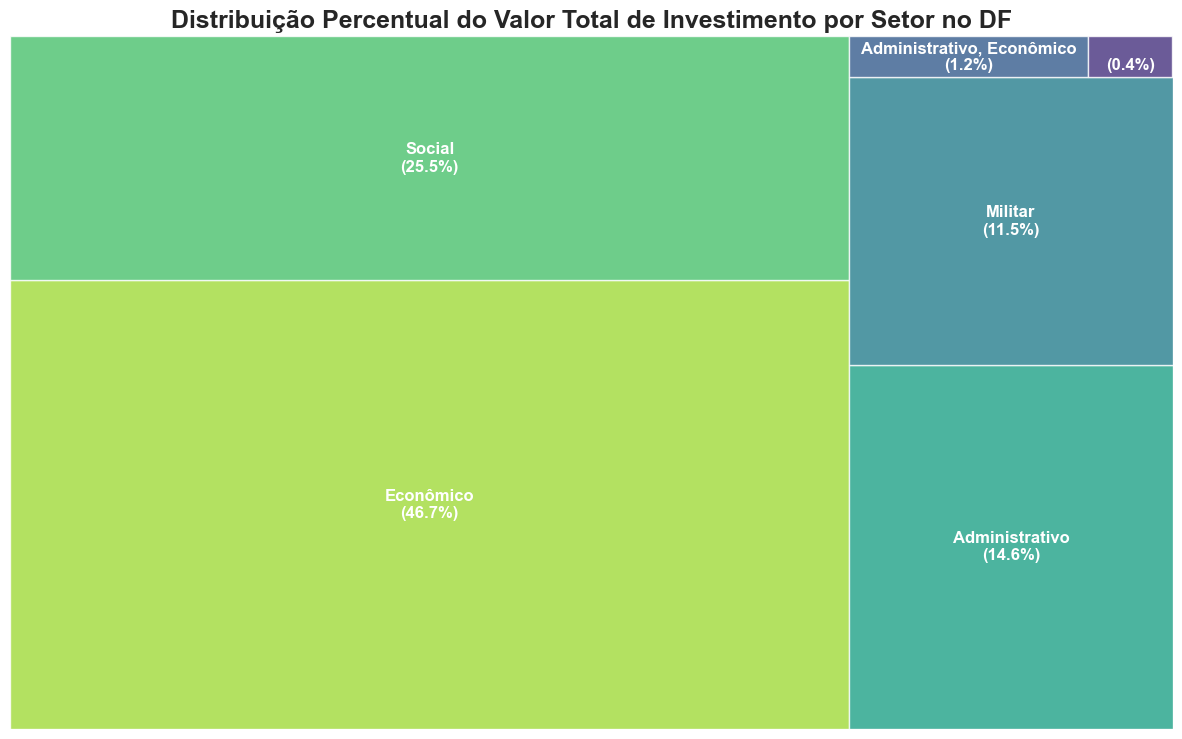


--- Tabela de Dados da Análise Setorial ---


,valor_total_previsto,Porcentagem (%)
eixo_descricao,,
Econômico,"R$ 3,922,884,622.32",46.74%
Social,"R$ 2,136,491,344.37",25.46%
Administrativo,"R$ 1,226,994,527.01",14.62%
Militar,"R$ 966,275,911.12",11.51%
"Administrativo, Econômico","R$ 103,283,499.41",1.23%
,"R$ 36,326,094.54",0.43%


In [420]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify # A biblioteca para criar o Treemap
from matplotlib.ticker import FuncFormatter

# --- Preparação dos Dados para a Análise Setorial ---
print("Preparando os dados para a análise setorial...")

# 1. Agrupa por 'eixo_descricao' e soma o valor total previsto.
#    .dropna() remove eixos que possam ser nulos.
analise_setorial = df_analise.dropna(subset=['eixo_descricao']).groupby('eixo_descricao')['valor_total_previsto'].sum().sort_values(ascending=False)

# 2. Calcula o valor total para encontrar as porcentagens
valor_total_geral = analise_setorial.sum()

# 3. Cria os labels para cada retângulo do gráfico
#    O label mostrará o nome do setor e a porcentagem do total (ex: "Econômico\n35.5%")
labels = [f"{nome}\n({(valor/valor_total_geral)*100:.1f}%)" for nome, valor in analise_setorial.items()]

# --- Criação do Gráfico Treemap ---
print("Gerando o gráfico Treemap por setor de investimento...")

plt.figure(figsize=(15, 9), dpi=100)
sns.set_theme(style="white") # Fundo branco fica melhor para treemaps

# 4. Gera as cores. Usamos uma paleta de cores 'viridis' com base no número de setores.
colors = sns.color_palette("viridis_r", n_colors=len(analise_setorial))

# 5. Plota o Treemap
squarify.plot(
    sizes=analise_setorial.values,
    label=labels,
    color=colors,
    alpha=0.8, # Deixa as cores um pouco translúcidas
    text_kwargs={'fontsize': 12, 'color': 'white', 'weight': 'bold'}
)

# --- Customização Final ---
plt.title('Distribuição Percentual do Valor Total de Investimento por Setor no DF', fontsize=18, weight='bold')
plt.axis('off') # Remove os eixos X e Y que não são necessários no treemap
plt.show()

# --- Tabela de Dados Complementar ---
print("\n--- Tabela de Dados da Análise Setorial ---")
tabela_setorial = analise_setorial.to_frame()
tabela_setorial['Porcentagem (%)'] = (tabela_setorial['valor_total_previsto'] / valor_total_geral * 100)
display(tabela_setorial.style.format({
    'valor_total_previsto': 'R$ {:,.2f}',
    'Porcentagem (%)': '{:.2f}%'
}))

**Insight da Análise 3:**

A análise do valor total de investimento por setor (eixo temático) revela as prioridades financeiras nos projetos do Distrito Federal. A distribuição é bastante concentrada:

1.  **Setor Econômico Domina:** O eixo **Econômico** é, de longe, o principal destino dos recursos, respondendo por quase metade (**46.74%**) do valor total previsto. Isso sugere um forte foco em projetos de infraestrutura de transporte, energia, mobilidade urbana e outras áreas que impulsionam a economia. 💰

2.  **Investimento Social Relevante:** O setor **Social** vem em segundo lugar, com **25.46%** dos investimentos. Isso indica uma prioridade significativa em áreas como educação, saúde, saneamento e habitação, que impactam diretamente a qualidade de vida da população. 🏘️🏥🎓

3.  **Administrativo e Militar:** Os eixos **Administrativo** (**14.62%**) e **Militar** (**11.51%**) também recebem fatias consideráveis, refletindo a necessidade de manutenção e expansão das estruturas governamentais e de defesa na capital federal. 🏛️✈️

4.  **Casos Híbridos/Não Definidos:** Uma pequena porcentagem de projetos se enquadra em mais de um eixo (como "Administrativo, Econômico") ou não teve seu eixo principal claramente definido (linha vazia na tabela), mas representam uma parcela mínima do investimento total (< 2%).

Simplificando, quase metade de todo o dinheiro planejado para novos projetos no DF vai para a área econômica (estradas, energia, etc.). Um quarto vai para a área social (escolas, hospitais), e o restante se divide principalmente entre projetos administrativos do governo e projetos militares.

---

### Análise 4: Quais são os principais órgãos executores de projetos no DF?

Identificar os principais executores nos permite entender quais entidades governamentais estão liderando o maior número de projetos. Para esta análise, vamos focar nos 10 órgãos com mais projetos, criando um gráfico de barras para visualizar essa concentração de responsabilidades.

In [421]:
top_10_executores = df_analise['executor_nome'].value_counts().nlargest(10)
print("\n--- Tabela de Frequência dos Top 10 Executores")
display(top_10_executores.to_frame(name='Contagem de Projetos'))


--- Tabela de Frequência dos Top 10 Executores


,Contagem de Projetos
executor_nome,
DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,70
INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA,48
FUNDACAO UNIVERSIDADE DE BRASILIA,45
COMANDO DO EXÉRCITO,40
DEPARTAMENTO DE POLICIA FEDERAL,29
COMANDO DA AERONÁUTICA,25
FUNDO DE SAUDE DO DISTRITO FEDERAL,25
Polícia Militar do Distrito Federal,24
DEPARTAMENTO DE ESTRADAS DE RODAGEM DO DISTRITO FEDERAL,21


C:\Users\User\AppData\Local\Temp\ipykernel_13844\1101530562.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


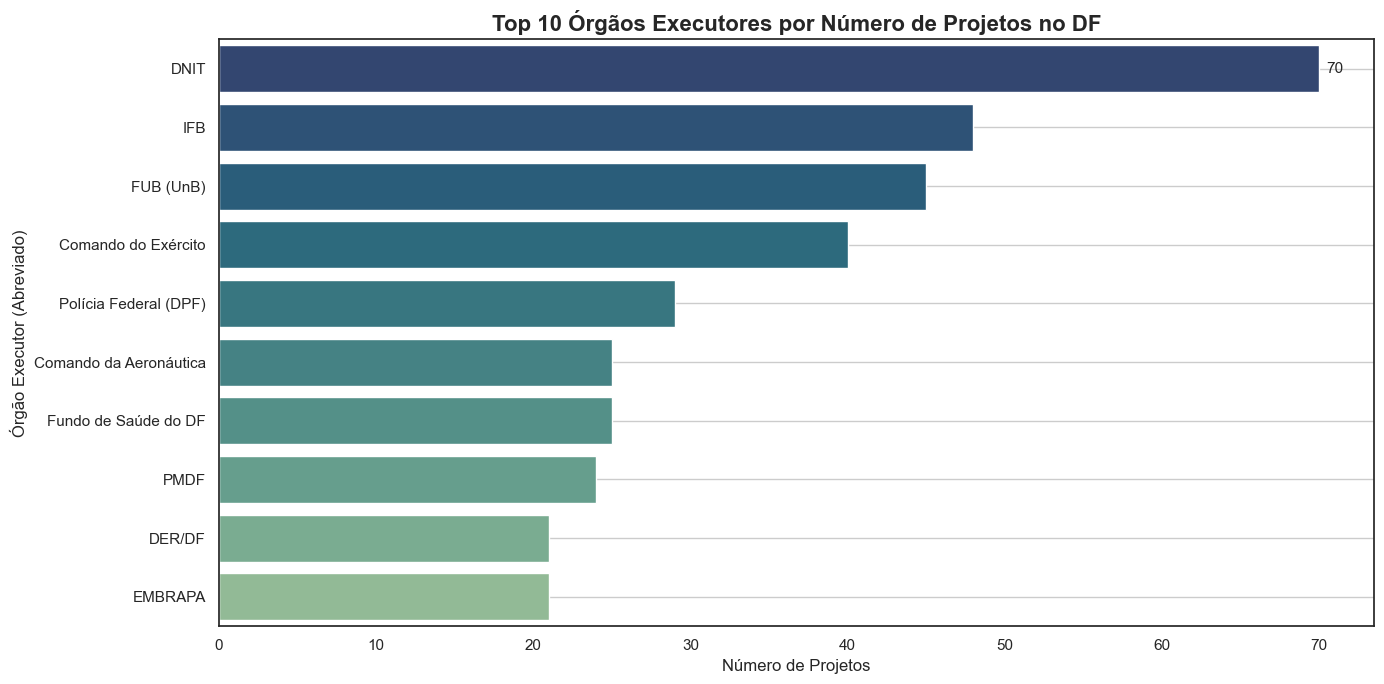

In [422]:
abreviacoes = {
    'DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES': 'DNIT',
    'INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA': 'IFB',
    'FUNDACAO UNIVERSIDADE DE BRASILIA': 'FUB (UnB)',
    'COMANDO DO EXÉRCITO': 'Comando do Exército',
    'DEPARTAMENTO DE POLICIA FEDERAL': 'Polícia Federal (DPF)',
    'FUNDO DE SAUDE DO DISTRITO FEDERAL': 'Fundo de Saúde do DF',
    'COMANDO DA AERONÁUTICA': 'Comando da Aeronáutica',
    'Polícia Militar do Distrito Federal': 'PMDF',
    'EMPRESA BRASILEIRA DE PESQUISA AGROPECUÁRIA': 'EMBRAPA',
    'DEPARTAMENTO DE ESTRADAS DE RODAGEM DO DISTRITO FEDERAL': 'DER/DF'
}

top_10_abreviado = top_10_executores.rename(index=abreviacoes)

ax = sns.barplot(
    x=top_10_abreviado.values, 
    y=top_10_abreviado.index, 
    palette='crest_r'
)

# --- Customização do Gráfico ---
ax.set_title('Top 10 Órgãos Executores por Número de Projetos no DF', fontsize=16, weight='bold')
ax.set_xlabel('Número de Projetos', fontsize=12)
ax.set_ylabel('Órgão Executor (Abreviado)', fontsize=12)

# Adiciona os rótulos de dados
ax.bar_label(ax.containers[0], fmt='%d', padding=5, fontsize=11)

ax.grid(axis='y')
plt.tight_layout()

# --- EXIBIÇÃO ---
plt.show()

**Insight da Análise 4:**

O gráfico dos 10 principais executores revela uma forte concentração de projetos em órgãos federais, destacando a importância do governo federal na infraestrutura e nos serviços do Distrito Federal.

1.  **Liderança do DNIT:** O Departamento Nacional de Infraestrutura de Transportes (DNIT) desponta como o principal executor, com 70 projetos. Isso indica um foco significativo em obras de infraestrutura de transporte, como rodovias e estradas, que são de competência federal.

2.  **Forte Presença de Educação e Forças Armadas:** O Instituto Federal de Brasília (IFB), a Fundação Universidade de Brasília (FUB/UnB) e órgãos militares como o Comando do Exército e da Aeronáutica figuram com destaque. Isso sugere um grande volume de investimentos na expansão e manutenção de estruturas educacionais e de defesa na capital.

3.  **Diversidade de Atuação:** A lista também inclui órgãos de segurança pública (Polícia Federal, PMDF), saúde (Fundo de Saúde do DF) e pesquisa (EMBRAPA), mostrando a diversidade dos investimentos que ocorrem no território do DF. O Departamento de Estradas de Rodagem do DF (DER/DF) é um dos representantes da esfera distrital na lista.

Em resumo, a maior parte dos projetos de investimento no DF é executada por grandes órgãos federais, especialmente nas áreas de transporte, educação e defesa. Isso reflete o status de Brasília como capital federal e sede de importantes instituições nacionais.

---

### Análise 5: Qual a distribuição dos projetos por situação?

Analisar a situação atual dos projetos é fundamental para entender o progresso das obras no DF nos mostrando um panorama claro de quantos projetos estão ativos, finalizados ou enfrentando problemas.

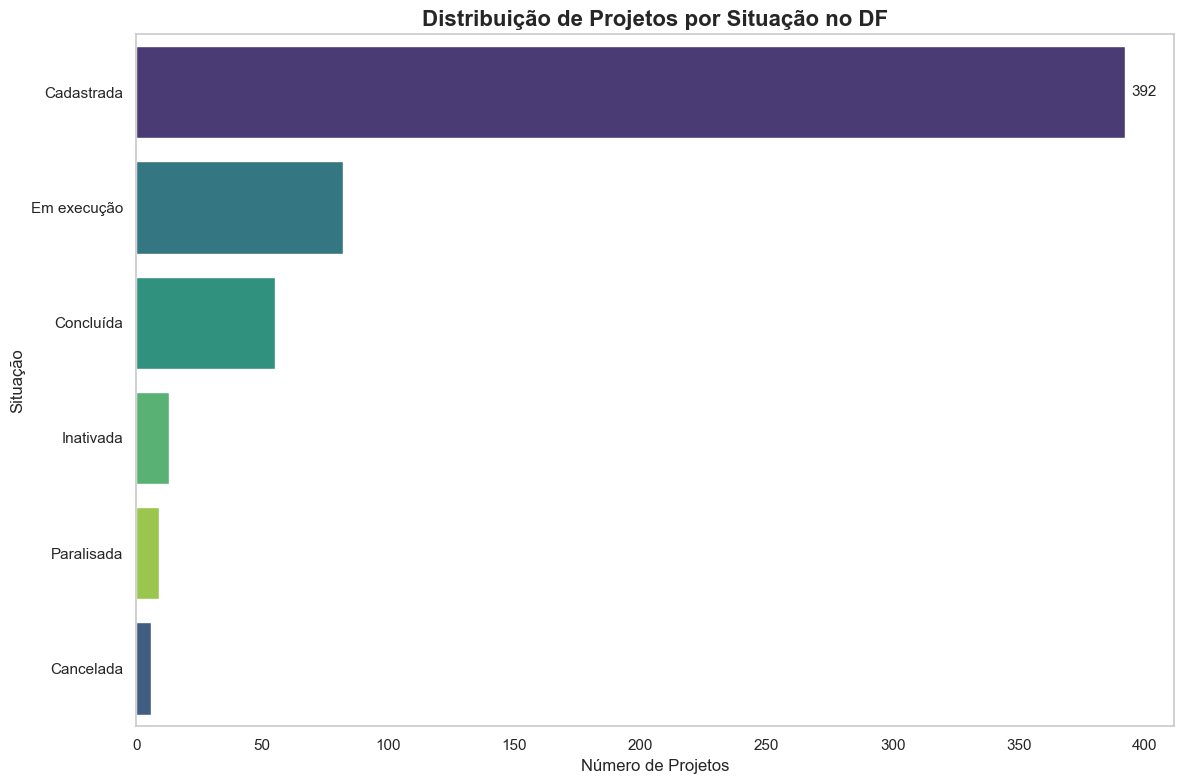


--- Tabela de Frequência por Situação ---


,Contagem,Porcentagem (%)
situacao,,
Cadastrada,392,70.38
Em execução,82,14.72
Concluída,55,9.87
Inativada,13,2.33
Paralisada,9,1.62
Cancelada,6,1.08


In [423]:
# Configurações de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Define a ordem das barras pela contagem (do maior para o menor)
ordem_situacao = df_analise['situacao'].value_counts().index

ax = sns.countplot(
    data=df_analise,
    y='situacao',
    order=ordem_situacao,
    palette='viridis',
    hue='situacao',
    legend=False
)

# --- Customização do Gráfico ---
ax.set_title('Distribuição de Projetos por Situação no DF', fontsize=16, weight='bold')
ax.set_xlabel('Número de Projetos', fontsize=12)
ax.set_ylabel('Situação', fontsize=12)

# Adiciona os rótulos de dados (a contagem) no final de cada barra
ax.bar_label(ax.containers[0], fmt='%d', padding=5, fontsize=11)

# Remove a grade vertical para um visual mais limpo
ax.grid(axis='x')
plt.tight_layout()

# --- EXIBIÇÃO ---
plt.show()

# --- Tabela de Dados Complementar ---
print("\n--- Tabela de Frequência por Situação ---")
# Calcula a contagem e a porcentagem de cada categoria
frequencia_situacao = df_analise['situacao'].value_counts().to_frame(name='Contagem')
frequencia_situacao['Porcentagem (%)'] = (frequencia_situacao['Contagem'] / len(df_analise) * 100).round(2)
display(frequencia_situacao)

**Insight da Análise 5:**

A análise da situação dos projetos revela um insight crucial sobre o estágio atual dos investimentos no Distrito Federal. O gráfico de barras mostra uma distribuição muito desigual entre as categorias:

1.  **Dominância de Projetos "Cadastrados":** Mais de **70%** dos projetos (392) estão na situação "Cadastrada". Isso significa que a grande maioria dos projetos listados ainda está na fase inicial, apenas registrados no sistema, mas **ainda não entraram em execução**.

2.  **Projetos em Andamento:** Cerca de **15%** dos projetos (82) estão atualmente "Em execução". Este número representa as obras que estão ativamente em andamento.

3.  **Concluídos vs. Problemas:** Aproximadamente **10%** dos projetos estão "Concluídos". Em contrapartida, somando as categorias negativas ("Inativada", "Paralisada", "Cancelada"), temos cerca de 5% dos projetos que enfrentaram algum tipo de problema ou interrupção.

Em termos simples, a grande maioria dos projetos de investimento planejados para o DF ainda está "no papel". Apenas uma fração menor está de fato em construção no momento. Isso pode indicar um grande volume de planejamento para o futuro, mas também pode sinalizar um possível gargalo entre a fase de cadastro e o início efetivo das obras.

